In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Завантаження даних
df = pd.read_csv("unclean_smartwatch_health_data.csv")
df.columns = [
    "User_ID", "Heart_Rate_BPM", "Blood_Oxygen_Percent",
    "Step_Count", "Sleep_Duration_Hours", "Activity_Level", "Stress_Level"
]
df = df.replace("ERROR", np.nan)
df = df.dropna(subset=["Heart_Rate_BPM", "Sleep_Duration_Hours", "Step_Count"])
numeric_columns = ["Heart_Rate_BPM", "Blood_Oxygen_Percent", "Step_Count", "Sleep_Duration_Hours", "Stress_Level"]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df["Activity_Level"] = df["Activity_Level"].str.replace("_", " ").str.title()
df.dropna(inplace=True)


In [4]:
# Нові змінні
df["Is_Stressed"] = df["Stress_Level"] >= 5
df["Sleep_Quality"] = pd.cut(df["Sleep_Duration_Hours"],
                             bins=[0, 5, 7, 24],
                             labels=["Poor", "Average", "Good"])

df["Step_Category"] = pd.cut(df["Step_Count"],
                             bins=[0, 5000, 10000, np.inf],
                             labels=["Low", "Medium", "High"])


In [5]:
# Розширений аналіз якості сну
df["Sleep_Length_Category"] = pd.cut(df["Sleep_Duration_Hours"],
                                     bins=[0, 5, 6.5, 8, 10, np.inf],
                                     labels=["Very Short", "Short", "Optimal", "Long", "Very Long"])

df["Potential_Poor_Sleep"] = (
    (df["Sleep_Duration_Hours"] < 6) &
    ((df["Stress_Level"] >= 5) | (df["Heart_Rate_BPM"] > 90))
)

def sleep_score(row):
    score = 0
    if 7 <= row["Sleep_Duration_Hours"] <= 9:
        score += 2
    elif 6 <= row["Sleep_Duration_Hours"] < 7 or 9 < row["Sleep_Duration_Hours"] <= 10:
        score += 1
    if row["Stress_Level"] < 3:
        score += 2
    elif row["Stress_Level"] < 5:
        score += 1
    if row["Heart_Rate_BPM"] < 60:
        score += 2
    elif row["Heart_Rate_BPM"] < 75:
        score += 1
    return score

df["Sleep_Quality_Score"] = df.apply(sleep_score, axis=1)
df["Sleep_Quality_Level"] = pd.cut(df["Sleep_Quality_Score"],
                                   bins=[-1, 2, 4, 6],
                                   labels=["Poor", "Average", "Good"])


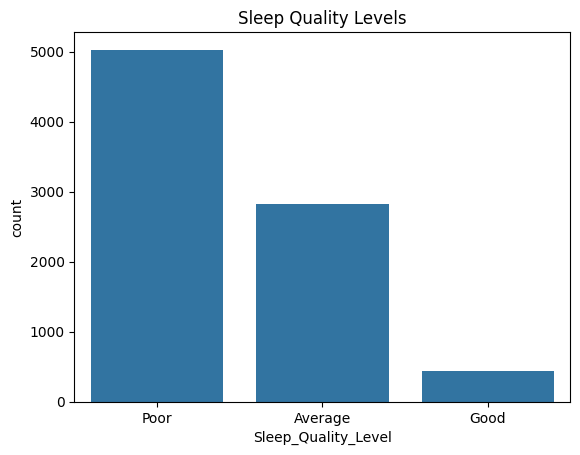

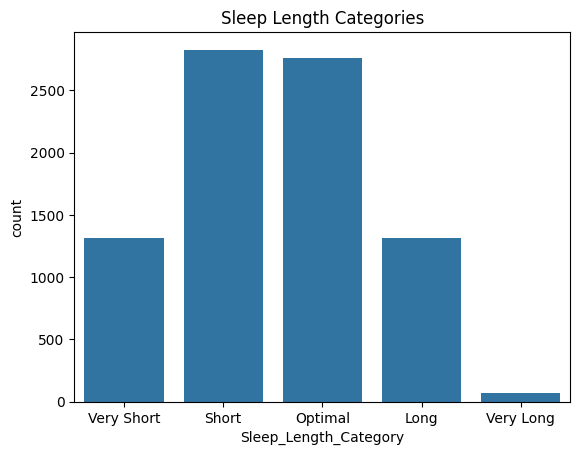

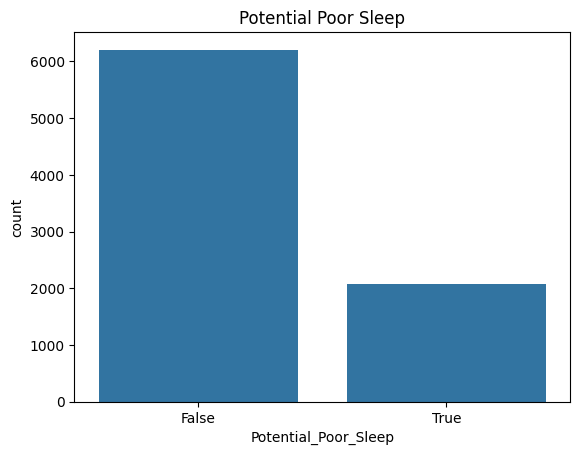

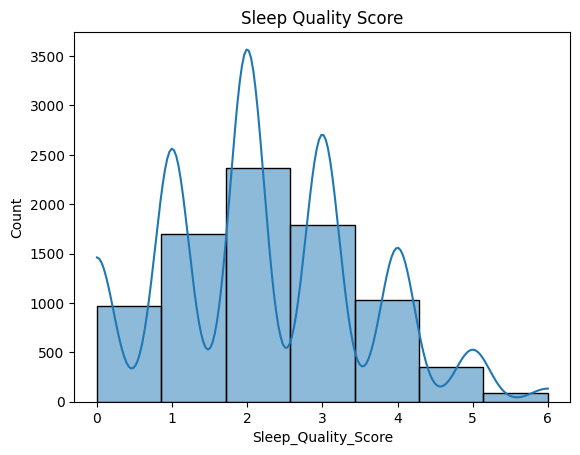

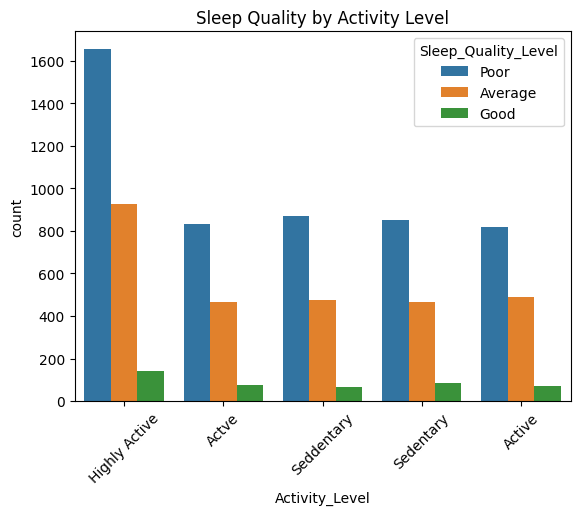

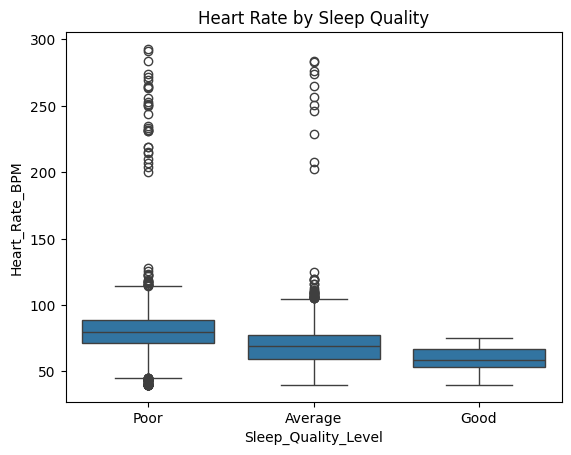

In [6]:
# Візуалізація
sns.countplot(data=df, x="Sleep_Quality_Level")
plt.title("Sleep Quality Levels")
plt.show()

sns.countplot(data=df, x="Sleep_Length_Category", order=["Very Short", "Short", "Optimal", "Long", "Very Long"])
plt.title("Sleep Length Categories")
plt.show()

sns.countplot(data=df, x="Potential_Poor_Sleep")
plt.title("Potential Poor Sleep")
plt.show()

sns.histplot(df["Sleep_Quality_Score"], bins=7, kde=True)
plt.title("Sleep Quality Score")
plt.show()

sns.countplot(data=df, x="Activity_Level", hue="Sleep_Quality_Level")
plt.title("Sleep Quality by Activity Level")
plt.xticks(rotation=45)
plt.show()

sns.boxplot(data=df, x="Sleep_Quality_Level", y="Heart_Rate_BPM")
plt.title("Heart Rate by Sleep Quality")
plt.show()


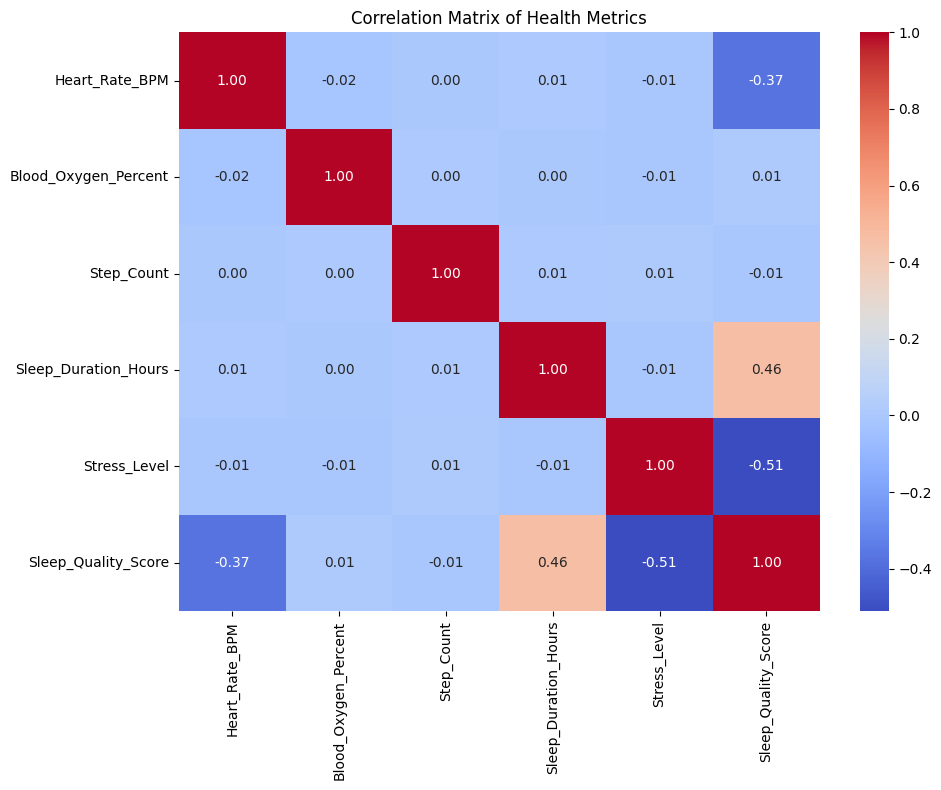

In [7]:
# Кореляційна матриця для числових показників
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr_matrix = df[[
    "Heart_Rate_BPM", "Blood_Oxygen_Percent", "Step_Count",
    "Sleep_Duration_Hours", "Stress_Level", "Sleep_Quality_Score"
]].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Health Metrics")
plt.tight_layout()
plt.show()

